In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
from scipy.special import gammainc

In [4]:
connectivity_min, connectivity_max = 0,15
delay_min, delay_max = 0,2.5
# random_input_span = (1.2,2.8)
# random_input_span = (9.5,9.5)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 100
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [5]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [6]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [7]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [8]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [9]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    table = table.dropna(axis=1, how='all')
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay')
    plt.close()
    return fig, ax

In [10]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [11]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [12]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [13]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
delay,,,,,,,,,,,,,,,
0.00,0.137090,0.129067,0.128021,0.127349,0.137697,0.168051,0.309622,0.761476,0.780875,0.771854,0.768153,0.756348,0.741315,0.726251,0.718204
0.25,0.137782,0.130053,0.121683,0.127571,0.137046,0.163165,0.344774,0.799464,0.815577,0.809370,0.796389,0.786250,0.771029,0.756085,0.741522
0.50,0.135367,0.128931,0.125088,0.130582,0.136547,0.172469,0.320689,0.801154,0.818234,0.810515,0.793990,0.785828,0.769575,0.758918,0.742789
0.75,0.137076,0.126043,0.123594,0.126629,0.133901,0.159583,0.316520,0.801554,0.818924,0.806550,0.797877,0.785056,0.769220,0.759962,0.743335
1.00,0.138302,0.127278,0.124935,0.129919,0.136935,0.171843,0.333373,0.797499,0.815293,0.811459,0.799409,0.779721,0.770834,0.760938,0.743827
1.25,0.136597,0.128076,0.124281,0.125029,0.137391,0.166778,0.305726,0.798585,0.817101,0.810257,0.801667,0.786031,0.773318,0.756751,0.749465
1.50,0.136542,0.126689,0.124999,0.126772,0.137618,0.166121,0.316679,0.803219,0.817301,0.809534,0.789213,0.780877,0.766907,0.763080,0.743496
1.75,0.136086,0.129676,0.125858,0.126001,0.138439,0.165294,0.345978,0.801177,0.816063,0.808642,0.793010,0.789994,0.771376,0.756704,0.750118
2.00,0.134473,0.129202,0.125337,0.129038,0.134965,0.164299,0.349284,0.801670,0.816867,0.807073,0.801469,0.783674,0.771581,0.763281,0.740377


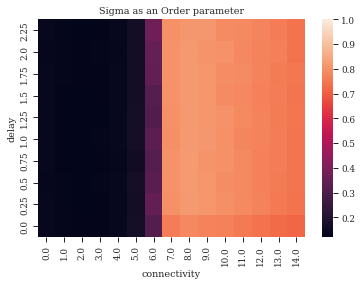

In [14]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

# ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [15]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


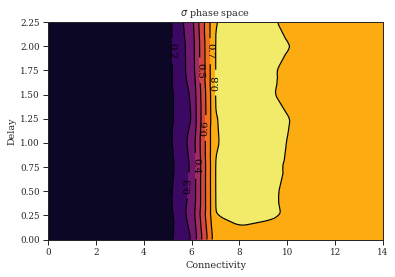

In [16]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


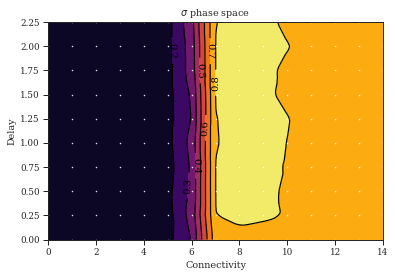

In [17]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

## Transition point approx.

In [18]:
def first_trans_point_non_repulsive(alpha, g, d):
    return 2*np.pi/gammainc(2,alpha*d*1)

def second_trans_point_non_repulsive(alpha, g, d):
    D = alpha*d
    return 2*np.pi*gammainc(2,D) / (1 - np.e**(-D)*(D**3 + 3*D**2 + 6*D + 6)/6 )

In [19]:
def first_trans_point_rotational(alpha, g, d, random_input_span):
    D = alpha*d
    a = random_input_span[0]
    num = a + 1
    denom = gammainc(2,D)**2 * (a - 1) - 2 * gammainc(2,D)
    return 2*np.pi*np.sqrt( num / denom )

# def first_trans_point_rotational(a_min, alpha, g, d):
#     num = a_min - 1
#     ro = num / denom
#     return 2*np.pi/gammainc(2,alpha*d*1)

# def first_trans_point_rotational(alpha, g, d, random_input_span):
#     D = alpha*d
#     g /= 2*np.pi
#     rho = (-2*g*np.arcsinh(((2*g**2-29)*np.sqrt(4*g**2-4))/(58*g**2-58)) + \
#            2*g*np.arcsinh(((2*g**2-21)*np.sqrt(4*g**2-4))/(42*g**2-42)) - \
#            2*np.arcsinh(27/np.sqrt(4*g**2-4)) + \
#            2*np.arcsinh(19/np.sqrt(4*g**2-4)) + \
#            np.sqrt(4*g**2+725) - \
#            np.sqrt(4*g**2+357) + \
#            (2*np.log(21/2)-2*np.log(29/2))*g)/2
#     return 2*np.pi / ( gammainc(2,D) * rho )

### First approx of transition point 

C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


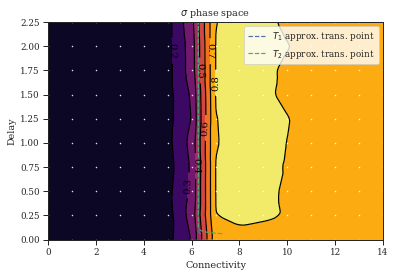

In [20]:

c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)

delay_mesh = np.arange(min(delay_arr)+0.06,max(delay_arr),0.01)
g_star_one = np.zeros_like(delay_mesh)
g_star_two = np.zeros_like(delay_mesh)

if neuron_model == current_models[2]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)
        g_star_two[i] = second_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    c_ax.plot( g_star_two, delay_mesh, 'g--', label = r'$T_2$ approx. trans. point')
elif neuron_model == current_models[1]:
    for i,d in enumerate(delay_mesh):
        g_star_one[i] = first_trans_point_rotational(alpha, g, d, random_input_span)
#         g_star_one[i] = first_trans_point_non_repulsive(alpha, g, d)

    c_ax.plot( g_star_one, delay_mesh, 'b--', label = r'$T_1$ approx. trans. point')
    
c_ax.legend(loc='upper right')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


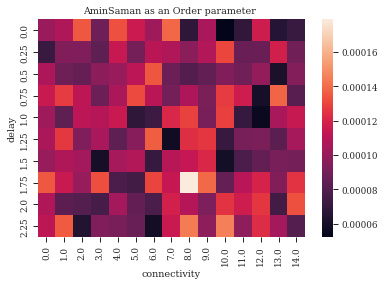

In [21]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    c_fig, c_ax = create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman')
    c_fig.savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [22]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
delay,,,,,,,,,,,,,,,
0.00,0.480769,0.602410,0.051308,0.020354,0.020032,0.059242,0.020076,0.062035,0.064725,0.067522,0.070077,0.072622,0.075188,0.077640,0.079872
0.25,0.657895,0.689655,0.628931,0.649351,0.523560,0.561798,0.561798,0.581395,0.609756,0.636943,0.662252,0.689655,0.709220,0.735294,0.757576
0.50,100.000000,1.960784,0.900901,1.020408,1.010101,1.052632,1.052632,1.098901,1.149425,1.204819,1.250000,1.298701,1.351351,1.388889,1.428571
0.75,100.000000,2.631579,1.818182,1.666667,1.587302,1.562500,1.562500,1.612903,1.694915,1.785714,1.851852,1.923077,2.000000,2.040816,2.127660
1.00,100.000000,3.448276,2.380952,2.173913,2.127660,2.083333,2.040816,2.127660,2.222222,2.325581,2.439024,2.500000,2.631579,2.702703,2.777778
1.25,100.000000,4.347826,2.941176,2.702703,2.631579,2.564103,2.564103,2.631579,2.777778,2.941176,3.030303,3.125000,3.225806,3.333333,3.448276
1.50,100.000000,5.555556,3.571429,3.225806,3.125000,3.125000,3.030303,3.225806,3.333333,3.448276,3.571429,3.703704,3.846154,4.000000,4.166667
1.75,100.000000,6.250000,4.166667,3.846154,3.703704,3.571429,3.571429,3.703704,3.846154,4.000000,4.166667,4.347826,4.545455,4.761905,4.761905
2.00,100.000000,7.142857,4.761905,4.347826,4.166667,4.166667,4.000000,4.166667,4.347826,4.545455,4.761905,5.000000,5.263158,5.263158,5.555556


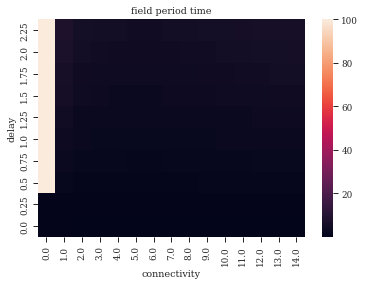

In [23]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [24]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


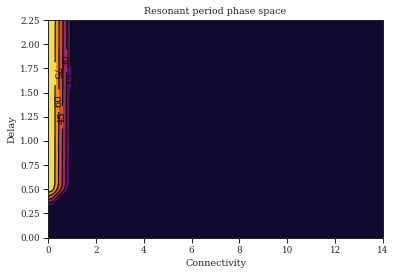

In [25]:
c_fig, c_ax = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [26]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
delay,,,,,,,,,,,,,,,
0.00,53.946266,45.386835,46.638936,57.289364,75.269107,123.245163,425.650527,2425.082927,2879.125639,2356.226758,2471.195116,2587.046892,1696.022853,2234.191342,2449.650326
0.25,62.250193,68.620752,77.226052,90.006426,77.117820,132.948142,495.744174,4147.448931,5353.454378,5366.603020,4963.301161,4631.896476,3535.226334,4701.257553,4521.042347
0.50,99.284371,75.868729,77.348720,97.649730,140.631374,219.689529,785.357197,4726.235095,4436.409569,5370.680180,4281.758378,4974.195695,4202.867299,4442.273517,4174.906624
0.75,144.936672,111.379756,108.692150,121.388191,155.540707,251.510126,897.073366,4370.772634,5375.097321,4262.080620,5052.584343,4609.567860,3694.240290,4460.912637,3597.040885
1.00,189.942252,146.251730,142.423060,160.221240,203.563881,328.061253,1054.165677,4509.890245,3791.623085,4724.197768,5224.709201,3529.813906,4783.657201,4710.511750,4535.542925


C:\Users\mohsen\AppData\Local\Temp\ipykernel_12212\2890352226.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


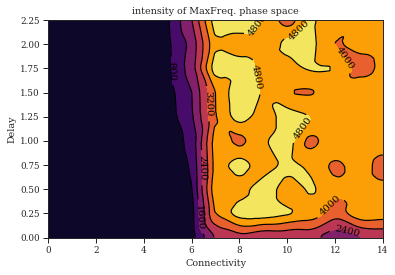

In [27]:
c_fig, c_ax = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [28]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)